# Lecture 11: Logistic Regression and Classification

In classification problem, the response variables $y$ are discrete, representing different catagories. For simplicity, we will first introduce the **binary classification case** -- $y$ has only two categories, denoted as $0$ and $1$.

## Model-setup

**Assumption 1**: Dependent on the variable $x$, the response variable $y$ has different **probabilities** to take value in 0 or 1. Instead of predicting exact value of 0 or 1, we are actually predicting the **probabilities**.

**Assumption 2**: Logistic function assumption. Given $x$, what is the probability to observe $y=1$?

$$P(y=1|\mathbf{x})=f(\mathbf{x};\mathbf{\beta}) = \frac{1}{1 + \exp(-\tilde{x}\mathbf{\beta})}
=: \sigma(\tilde{x}\mathbf{\beta}). $$

where $\sigma(z)=\frac{1}{1+\exp{(-x)}}$ is called [standard logistic function](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=Logistic%20regression%20is%20a%20statistical,a%20form%20of%20binary%20regression), or sigmoid function in deep learning. Recall that $\beta\in\mathbb{R}^{p+1}$ and $\tilde{x}$ is the "augmented" sample with first element one to incorporate intercept in the linear function.

**Equivalent expression**:
  - Denote $p = P(y=1|\mathbf{x})$, then we can write in linear form
  $$\ln\frac{p}{1-p}=\tilde{x}\beta$$
  - Since $y$ only takes value in 0 or 1, we have
  $$P(y|\mathbf{x},\beta) = f(\mathbf{x};\beta)^y \big(1 - f(\mathbf{x};\beta) \big)^{1-y}$$
  
**MLE (Maximum Likelihood Estimation)**

Assume the samples are independent. The overall probibility to witness the whole training dataset
$$
{\begin{aligned}
&P(\mathbf{y}\; | \; \mathbf{X};\beta )\\
=&\prod _{i=1}^N P\left(y^{(i)}\mid \mathbf{x}^{(i)};\beta\right)\\
=&\prod_{i=1}^N f\big(\mathbf{x}^{(i)};\beta \big)^{y^{(i)}} 
\Big(1-f\big(\mathbf{x}^{(i)};\beta\big) \Big)^{\big(1-y^{(i)}\big)}
\end{aligned}}.
$$

By maximizing the logarithm of likelihood function, then we derive the **loss function** to be minimized
$$
L (\beta) = L (\beta; X,\mathbf{y}) = - \frac{1}{N}\sum_{i=1}^N 
\Bigl\{y^{(i)} \ln\big( f(\mathbf{x}^{(i)};\beta) \big) 
+ (1 - y^{(i)}) \ln\big( 1 - f(\mathbf{x}^{(i)};\beta) \big) \Bigr\}.
$$

The loss function also has clear probabilistic interpretations. Given $i$-th sample, the vector of true labels $(y^{i},1-y^{i})$ can also be viewed as the probability distribution. Then the loss function is the mean of all [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) across samples, i.e. "distance" between true probability distribution and estimated probability distribution via logistic model.

## Algorithm

Take the gradient (left as exercise -- if you like)
$$
\frac{\partial L (\beta)}{\partial \beta_{k}} =\frac{1}{N}\sum_{i=1}^N  \big(\sigma(\tilde{x}^{(i)}\beta)  - y^{(i)} \big) \tilde{x}^{(i)}_k.
$$

In vector form
$$
\nabla_{\beta} \big( L (\beta) \big) = \sum_{i=1}^N  \big(\sigma(\tilde{x}^{(i)})  - y^{(i)} \big) \tilde{x}^{(i)} 
=\frac{1}{N}\sum_{i=1}^N \big( f(\mathbf{x}^{(i)};\beta)  - y^{(i)} \big) \tilde{x}^{(i)}.
$$

This is still the nonlinear function of $\beta$, indicating that we cannot derive something like "normal equations" in OLS. The solution here is [numerical optimization](https://github.com/Jaewan-Yun/optimizer-visualization).

The simplest algorithm in optimization is [gradient descent (GD)](https://en.wikipedia.org/wiki/Gradient_descent#:~:text=Gradient%20descent%20is%20a%20first,function%20at%20the%20current%20point.). $$\beta^{k+1}=\beta^{k}-\eta\nabla L(\beta^{k}).$$

Here the step size $\eta$ is also called **learning rate** in machine learning. Note that it is indeed the Euler's scheme to solve the ODE $$\dot{\beta} = -\nabla L(\beta).$$

By setting certain stopping criterion for GD, we think that we have approximated the optimized solution $\hat{\beta}$.

## Making predictions

Now with the estimated $\hat{\beta}$ and given a new data $x^{new}$, we calculate the probability that $y^{new}=1$ as $f(\mathbf{x};\mathbf{\beta})$. If is greater than 0.5, we assign that $y^{new}=1$. 

For the whole dataset, the **accuracy** is defined as ratio of number of correct predictions to the total number of samples.

## Example Code

In [1]:
import numpy as np

class myLogisticRegression_binary():
    """ Logistic Regression classifier -- this only works for the binary case.
    Parameters:
    -----------
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    """
    def __init__(self, learning_rate=.1):
        
        # learning rate can also be in the fit method
        self.learning_rate = learning_rate
        

    def fit(self, data, y, n_iterations = 1000):
        """ 
        don't forget the document string in methods
        """
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        eta = self.learning_rate
        
        beta  = np.zeros(np.shape(X)[1]) # initialize beta, can be other choices

        for k in range(n_iterations):
            dbeta = self.loss_gradient(beta,X,y) # write another function to compute gradient
            beta = beta - eta * dbeta # the formula of GD
            # this step is optional -- just for inspection purposes
            if k % 500 == 0: # pprint loss every 500 steps
                print("loss after", k+1, "iterations is: ", self.loss(beta,X,y))
        
        self.coeff = beta
        
    def predict(self, data):
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        beta = self.coeff # the estimated beta
        y_pred = np.round(self.sigmoid(np.dot(X,beta))).astype(int) # >0.5: ->1 else,->0 -- note that we always use Numpy universal functions when possible
        return y_pred
    
    def score(self, data, y_true):
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        y_pred = self.predict(data)
        acc = np.mean(y_pred == y_true) # number of correct predictions/N
        return acc
    
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def loss(self,beta,X,y):
        f_value = self.sigmoid(np.matmul(X,beta))
        loss_value = np.log(f_value + 1e-10) * y + (1.0 - y)* np.log(1 - f_value + 1e-10) # avoid nan issues
        return -np.mean(loss_value)
                          
    def loss_gradient(self,beta,X,y):
        f_value = self.sigmoid(np.matmul(X,beta))                  
        gradient_value = (f_value - y).reshape(-1,1)*X # this is the hardest expression -- check yourself. It's called Numpy broadcasting
        return np.mean(gradient_value, axis=0)

In [2]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y = True)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [4]:
X_train.shape

(512, 30)

In [5]:
%%time
lg = myLogisticRegression_binary(learning_rate=1e-5)
lg.fit(X_train,y_train,n_iterations = 20000) # what about increase n_iterations?

loss after 1 iterations is:  0.7704000919325609
loss after 501 iterations is:  0.3038878556607375
loss after 1001 iterations is:  0.2646726705164665
loss after 1501 iterations is:  0.24813479245950681
loss after 2001 iterations is:  0.2389480595788275
loss after 2501 iterations is:  0.23311785521728876
loss after 3001 iterations is:  0.22909746536348718
loss after 3501 iterations is:  0.22615149966747047
loss after 4001 iterations is:  0.2238860140178029
loss after 4501 iterations is:  0.22207285161370108
loss after 5001 iterations is:  0.22057221113785216
loss after 5501 iterations is:  0.2192946215702638
loss after 6001 iterations is:  0.21818078310948252
loss after 6501 iterations is:  0.21719023774728446
loss after 7001 iterations is:  0.21629469731306186
loss after 7501 iterations is:  0.21547395937965436
loss after 8001 iterations is:  0.21471332436186458
loss after 8501 iterations is:  0.21400191582326006
loss after 9001 iterations is:  0.21333156155309688
loss after 9501 iterat

In [6]:
lg.score(X_test,y_test)

1.0

In [7]:
lg.score(X_train,y_train)

0.916015625

In [8]:
lg.predict(X_test)

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1])

In [9]:
y_test

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1])

In [10]:
lg.coeff

array([ 2.66882874e-03,  1.83927907e-02, -4.36239390e-03,  8.66487934e-02,
        1.49727981e-02,  5.50578751e-05, -6.71061493e-04, -1.14024608e-03,
       -4.51040831e-04,  1.06678514e-04,  8.62208844e-05,  1.72299429e-04,
        4.51211649e-04, -2.32558967e-03, -2.93966958e-02, -5.28628701e-06,
       -1.83325756e-04, -2.46370803e-04, -5.80574855e-05, -9.52561495e-06,
       -1.16457037e-05,  1.92488199e-02, -1.67105144e-02,  6.60427872e-02,
       -2.88220491e-02, -2.09664782e-05, -2.48568195e-03, -3.30713576e-03,
       -8.60537728e-04, -1.96407733e-04, -8.95680417e-05])

In [11]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

/Users/cliffzhou/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9824561403508771

In [12]:
clf.score(X_train,y_train)

0.953125

It's very normal that our result is different with sklearn. In sklearn [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression), they use different algorithms to solve the optimization problem, and even the model is different (adding regularization terms!)

## Multi-class Case

### Model 
Let $\tilde{x}\in\mathbb{R}^{p+1}$ denotes the augmented row vector (one sample). We approximate the probabilities to take value in $K$ classes as

$$
f(\mathbf{x};W) =
\begin{pmatrix}
P(y = 1 | \mathbf{x}; \mathbf{w}) \\
P(y = 2 | \mathbf{x}; \mathbf{w}) \\
\vdots \\
P(y = K | \mathbf{x}; \mathbf{w})
\end{pmatrix}
=
\frac{1}{ \sum_{k=1}^{K}{\exp\big(\tilde{x}\mathbf{w}_{k}\big) }}
\begin{pmatrix}
\exp(\tilde{x}\mathbf{w}_{1} ) \\
\exp(\tilde{x}\mathbf{w}_{2} ) \\
\vdots \\
\exp(\tilde{x}\mathbf{w}_{K} ) \\
\end{pmatrix}.
$$
where we have $K$ sets of parameters, $\mathbf{w}_1, \mathbf{w}_2, \dots, \mathbf{w}_K$, and the sum factor normalizes the results to be a probability.

$\mathbf{W}$ is an $(p+1)\times K$ matrix containing all $K$ sets of parameters, obtained by concatenating $\mathbf{w}_1, \mathbf{w}_2, \dots, \mathbf{w}_K$ into columns, so that $\mathbf{w}_k = (w_{k0}, \dots, w_{kp})^{\top}\in \mathbb{R}^{p+1}$.

$$
\mathbf{w} = \left(
\begin{array}{cccc}| & | & | & | \\
\mathbf{w}_1 & \mathbf{w}_2 & \cdots & \mathbf{w}_K \\
| & | & | & |
\end{array}\right),
$$
and $\tilde{X}\mathbf{W}$ is valid and useful in vectorized code.

----

### Loss function

Define the following indicator function:
$$
1_{\{y = k\}} = 1_{\{k\}}(y) = \delta_{yk} = \begin{cases}
1 & \text{when } y = k,
\\[5pt]
0 & \text{otherwise}.
\end{cases}
$$

Loss function is again using the cross entropy:

$$
\begin{aligned}
L (\mathbf{W};X,\mathbf{y})  & = - \frac{1}{N}\sum_{i=1}^N \sum_{k=1}^K
\Bigl\{ 1_{\{y^{(i)} = k\}} \ln P\big(y^{(i)}=k | \mathbf{x}^{(i)} ; \mathbf{w} \big) \Bigr\}
\\
 & = - \frac{1}{N}\sum_{i=1}^N \sum_{k=1}^K
\left\{1_{\{y^{(i)} = k\}} \ln \Bigg( \frac{\exp(\tilde{x}^{(i)}\mathbf{w}_{k})}{\sum_{m=1}^{K} 
\exp\big(\tilde{x}^{(i)}\mathbf{w}_m\big) }  \Bigg)\right\}.
\end{aligned}
$$

Notice that for each term in the summation over N (i.e. fix sample i), only one term is non-zero in the sum of K elements due to the indicator function.

----

### Gradient descent
After **careful calculation**, the gradient of $L$ with respect the whole $k$-th set of weights is then:

$$
\frac{\partial L }{\partial \mathbf{w}_{k}}
= 
\frac{1}{N}\sum_{i=1}^N 
\left(    \frac{\exp(\tilde{x}^{(i)}\mathbf{w}_{k})} {\sum_{m=1}^{K} 
\exp(\tilde{x}^{(i)}\mathbf{w}_m)} -1_{\{y^{(i)} = k\}} 
\right)\tilde{x}^{(i)}\in\mathbb{R}^{p+1}.
$$

In writing the code, it's helpful to make this as the column vector, and stack all the $K$ gradients together as a new matrix $\mathbf{dW}\in\mathbb{R}^{(p+1)\times K}$. This makes the update of matrix $\mathbf{W}$ very convenient in gradient descent.

----

### Prediction
The largest estimated probability's class as this sample's predicted label.
$$
\hat{y} = \operatorname{arg}\max_{j} P\big(y = j| \mathbf{x}\big),
$$

In [16]:
import numpy as np

class myLogisticRegression():
    """ Logistic Regression classifier -- this also works for the multiclass case.
    Parameters:
    -----------
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    """
    def __init__(self, learning_rate=.1):
        
        # learning rate can also be in the fit method
        self.learning_rate = learning_rate
        

    def fit(self, data, y, n_iterations = 1000):
        """ 
        don't forget the document string in methods
        """
        self.K = max(y)+1 # specify number of classes in y
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        eta = self.learning_rate
        
        W  = np.zeros((np.shape(X)[1],max(y)+1)) # initialize beta, can be other choices

        for k in range(n_iterations):
            dW = self.loss_gradient(W,X,y) # write another function to compute gradient
            W = W - eta * dW # the formula of GD
            # this step is optional -- just for inspection purposes
            if k % 500 == 0: # print loss every 500 steps
                print("loss after", k+1, "iterations is: ", self.loss(W,X,y))
        
        self.coeff = W
        
    def predict(self, data):
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        W = self.coeff # the estimated W
        y_pred = np.argmax(self.sigma(X,W), axis =1) # the category with largest probability
        return y_pred
    
    def score(self, data, y_true):
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        y_pred = self.predict(data)
        acc = np.mean(y_pred == y_true) # number of correct predictions/N
        return acc
    
    def sigma(self,X,W):
        s = np.exp(np.matmul(X,W))
        total = np.sum(s, axis=1).reshape(-1,1)
        return s/total
    
    def loss(self,W,X,y):
        f_value = self.sigma(X,W)
        K = self.K 
        loss_vector = np.zeros(X.shape[0])
        for k in range(K):
            loss_vector += np.log(f_value+1e-10)[:,k] * (y == k) # avoid nan issues
        return -np.mean(loss_vector)
                          
    def loss_gradient(self,W,X,y):
        f_value = self.sigma(X,W)
        K = self.K 
        dLdW = np.zeros((X.shape[1],K))
        for k in range(K):
            dLdWk =(f_value[:,k] - (y==k)).reshape(-1,1)*X # Numpy broadcasting
            dLdW[:,k] = np.mean(dLdWk, axis=0)   # RHS is 1D Numpy array -- so you can safely put it in the k-th column of 2D array dLdW
        return dLdW

In [14]:
from sklearn.datasets import load_digits
X,y = load_digits(return_X_y = True)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [17]:
lg = myLogisticRegression(learning_rate=1e-4)
lg.fit(X_train,y_train,n_iterations = 20000) # what about change the parameters?

loss after 1 iterations is:  2.2975031101988965
loss after 501 iterations is:  0.9747646840265886
loss after 1001 iterations is:  0.6271544957404386
loss after 1501 iterations is:  0.48465074291917476
loss after 2001 iterations is:  0.4067886795416971
loss after 2501 iterations is:  0.3569853787369549
loss after 3001 iterations is:  0.3219498860091718
loss after 3501 iterations is:  0.2957112499207807
loss after 4001 iterations is:  0.27517638606506345
loss after 4501 iterations is:  0.2585728459578632
loss after 5001 iterations is:  0.24480630370680928
loss after 5501 iterations is:  0.23316150090969132
loss after 6001 iterations is:  0.22314954388974834
loss after 6501 iterations is:  0.21442400929215735
loss after 7001 iterations is:  0.2067320488693829
loss after 7501 iterations is:  0.19988447822601138
loss after 8001 iterations is:  0.19373672640885967
loss after 8501 iterations is:  0.1881762834198265
loss after 9001 iterations is:  0.1831141858457873
loss after 9501 iterations 

In [18]:
lg.score(X_test,y_test)

0.9722222222222222

In [19]:
np.where(lg.predict(X_test)!=y_test)

(array([  5,  71, 133, 149, 159]),)

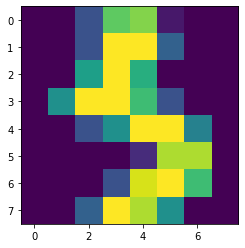

In [20]:
import matplotlib.pyplot as plt
plt.imshow(X_test[149,].reshape(8,8))

In [21]:
print(lg.predict(X_test)[149],y_test[149])

5 3


For multi-class classification, the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) can provide as more details.

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,lg.predict(X_test))

array([[17,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 17,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 16,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 25,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 21,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 19,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 18,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  8,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1, 24]])

## Tricks in training: Stochastic Gradient Descent (SGD)

When you're doing the final project, it's very likely that you might lose patience -- training on the 60,000 MNIST data is VERY SLOW! (of course it's not an excuse to abandon the project lol)

To speed up the training process (most importantly the optimization algorithm), there are two directions of general strategies:
    - find better algorithm whose convergence is faster (you take less steps to arrive at the minimum)
    - save the computational cost within each step
    
Of course there are trade-offs between these two directions.

    
**Basic observation of SGD**: Calculating the gradient in each step is TOO EXPENSIVE! 

Recall that in general supervised learning, $$\nabla_{\beta} L(\beta;X,Y) = \frac{1}{N}\sum_{i=1}^{N}\nabla_{\beta}l(\beta;x^{(i)},y^{(i)})$$

It means that we need to implement 60,000 sum calculation in the single step!!!

**"Wild" yet smart idea**: Note that the RHS is in the form of "population average". The basic intuitive from statistics is that we can use "sample means" to replace "population average". If you're bold enough -- just randomly pick up ONE single sample and use this value to replace "population average"!

- Herustic expression of "pure stochastic" SGD: $$\beta^{k+1}=\beta^{k}-\eta \nabla_{\beta}l(\beta^{k};x^{(r)},y^{(r)}),$$ where $r$ denotes the index randomly picked during this step.

    
- (mini-batch SGD, or "standard" SGD):$$\beta^{k+1}=\beta^{k}-\eta \frac{1}{n_{B}}\sum_{k=1}^{n_{B}}\nabla_{\beta}l(\beta^{k};x^{(k)},y^{(k)}),$$ where $n_b$ denotes the size of mini-batch, and the average is taken over the $n_b$ random samples.
    

In actual programming, we don't want to generate new random numbers in each step, nor want to "waste" some samples -- we desire all training data can be used during SGD. It is very useful to adopt the "epoch-batch" strategy (or called cyclic rule) through permutation of the data.

> Choose initial guess $\beta^{0}$, step size (learning rate) $\eta$, <br>
batch size $n_B$, number of inner iterations $M\leq N/n_B$, number of epochs $n_E$ <br><br>
>    For epoch $n=1,2, \cdots, n_E$<br>
>    &nbsp;&nbsp;&nbsp;&nbsp; $\beta^{0}$ for the current epoch is $\beta^{M+1}$ for the previous epoch.<br>
>    &nbsp;&nbsp;&nbsp;&nbsp; Randomly shuffle the training samples.<br>
>    &nbsp;&nbsp;&nbsp;&nbsp; For $m=0,1,2, \cdots, M-1$<br>
>    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    $\displaystyle\beta^{m+1} = {\beta}^m -  \frac{\eta}{n_B}\sum_{i=1}^{n_B} \nabla_{\beta} l(\beta^{m}; 
x^{(m*n_{B}+i)},y^{(m*n_{B}+i)})$

If the gradient loss of your program is written in a highly vectorized way (support data matrix as input), then you can simply make the data matrix within the mini-batch as the input in each GD update. Below is the example based on our previous binary logistic regression codes. 

In practice, you may also find it helpful to adjust the stepsize (learning rate) during the iteration.

In [23]:
import numpy as np

class myLogisticRegression_binary():
    """ Logistic Regression classifier -- this only works for the binary case. Here we provide the option of SGD in optimization.
    Parameters:
    -----------
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    """
    def __init__(self, learning_rate=.001, opt_method = 'SGD', num_epochs = 50, size_batch = 20):
        
        # learning rate can also be in the fit method
        self.learning_rate = learning_rate
        self.opt_method = opt_method
        self.num_epochs = num_epochs
        self.size_batch = size_batch
        
        
    def fit(self, data, y, n_iterations = 1000):
        """ 
        don't forget the document string in methods
        """
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        eta = self.learning_rate
        
        beta  = np.zeros(np.shape(X)[1]) # initialize beta, can be other choices

        if self.opt_method == 'GD':
            for k in range(n_iterations):
                dbeta = self.loss_gradient(beta,X,y) # write another function to compute gradient
                beta = beta - eta * dbeta # the formula of GD
                # this step is optional -- just for inspection purposes
                if k % 500 == 0: # pprint loss every 50 steps
                    print("loss after", k+1, "iterations is: ", self.loss(beta,X,y))
        
        if self.opt_method == 'SGD':
            N = X.shape[0]
            num_epochs = self.num_epochs
            size_batch = self.size_batch
            num_iter = 0
            for e in range(num_epochs):
                shuffle_index = np.random.permutation(N) # in each epoch, we first reshuffle the data to create "randomness"
                for m in range(0,N,size_batch):   # m is the starting index of mini-batch
                    i = shuffle_index[m:m+size_batch] # index of samples in the mini-batch
                    dbeta = self.loss_gradient(beta,X[i,:],y[i]) # only use the data in mini-batch to compute gradient. Note the average is taken in the loss_gradient function
                    beta = beta - eta * dbeta # the formula of GD, but this time dbeta is different
                
                    if e % 1 == 0 and num_iter % 50 ==0: # print loss during the training process
                        print("loss after", e+1, "epochs and ", num_iter+1, "iterations is: ", self.loss(beta,X,y))
        
                    num_iter = num_iter +1  # number of total iterations
            
        self.coeff = beta
        
    def predict(self, data):
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        beta = self.coeff # the estimated beta
        y_pred = np.round(self.sigmoid(np.dot(X,beta))).astype(int) # >0.5: ->1 else,->0 -- note that we always use Numpy universal functions when possible
        return y_pred
    
    def score(self, data, y_true):
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        y_pred = self.predict(data)
        acc = np.mean(y_pred == y_true) # number of correct predictions/N
        return acc
    
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def loss(self,beta,X,y):
        f_value = self.sigmoid(np.matmul(X,beta))
        loss_value = np.log(f_value + 1e-10) * y + (1.0 - y)* np.log(1 - f_value + 1e-10) # avoid nan issues
        return -np.mean(loss_value)
                          
    def loss_gradient(self,beta,X,y):
        f_value = self.sigmoid(np.matmul(X,beta))                  
        gradient_value = (f_value - y).reshape(-1,1)*X # this is the hardest expression -- check yourself
        return np.mean(gradient_value, axis=0)

You will find adapting the SGD codes above to multi-class logistic regression is very helpful in doing your final project! (although it's not basic requirement). Here is the very intuitive argument when SGD can boost the algorithms.

Suppose in the training dataset you have $N= 60,000$ samples. With GD, each iteration will cost 60,000 summations. Now consider using SGD. We have the mini-batch size of 30. Then each iteration will cost only 30 sums. For a complete epoch, you have 60,000 sums -- the same with GD, but you have already iterated for 2000 steps!

Of course you may argue that the "quality" of steps in GD is "far better" than SGD. Surely there is the trade-off, but pratically [the inferior performace of SGD in convergence does not obscure its super efficiency over GD](https://www.stat.cmu.edu/~ryantibs/convexopt/lectures/stochastic-gd.pdf). In fact, SGD is the de facto optimization method in deep learning. (SGD and BP -- backward propogation to calculate the gradient are the two fundamental cornerstones in deep learning.)

Next, we compare GD and SGD with the UCI ["adult" dataset](https://archive.ics.uci.edu/ml/datasets/adult) to predict income. Note that it is a binary classification problem.

In [24]:
import pandas as pd
df = pd.read_csv('adult.csv')
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [25]:
from numpy import nan
df = df.replace('?',nan) #dealing with missing values -- ? in original dataset
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [26]:
df.dropna(inplace = True) # drop missing values
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [27]:
df.drop(columns=['fnlwgt','native-country'], inplace=True) # drop some variables we are not interested
df

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,>50K
5,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,<=50K
48838,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,>50K
48839,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,<=50K
48840,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,<=50K


In [28]:
from sklearn.preprocessing import LabelEncoder
df_clean = df.apply(LabelEncoder().fit_transform) # transform the categorical variables into numerical
df_clean

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,income
0,8,2,1,6,4,6,3,2,1,0,0,39,0
1,21,2,11,8,2,4,0,4,1,0,0,49,0
2,11,1,7,11,2,10,0,4,1,0,0,39,1
3,27,2,15,9,2,6,0,2,1,96,0,39,1
5,17,2,0,5,4,7,1,4,1,0,0,29,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,10,2,7,11,2,12,5,4,0,0,0,37,0
48838,23,2,11,8,2,6,0,4,1,0,0,39,1
48839,41,2,11,8,6,0,4,4,0,0,0,39,0
48840,5,2,11,8,4,0,3,4,1,0,0,19,0


Note that it is not best way to encode the data. Please see other solutions in [kaggle](https://www.kaggle.com/wenruliu/adult-income-dataset/notebooks).

In [29]:
y = df_clean['income'].to_numpy()
X = df_clean.drop(columns = 'income').to_numpy()

In [30]:
X.shape

(45222, 12)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [32]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

/Users/cliffzhou/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8273269953570639

In [34]:
lg_gd = myLogisticRegression_binary(learning_rate=1e-6, opt_method = 'GD')
lg_sgd = myLogisticRegression_binary(learning_rate=1e-6, opt_method = 'SGD', num_epochs = 15, size_batch = 40)

In [35]:
%%time
lg_gd.fit(X_train,y_train,n_iterations = 15000)

loss after 1 iterations is:  0.6930358550277247
loss after 501 iterations is:  0.6503339171382144
loss after 1001 iterations is:  0.6250322404153786
loss after 1501 iterations is:  0.6091127195017652
loss after 2001 iterations is:  0.5984037857262678
loss after 2501 iterations is:  0.590712724359857
loss after 3001 iterations is:  0.5848586907302407
loss after 3501 iterations is:  0.5801861202580018
loss after 4001 iterations is:  0.5763181444418489
loss after 4501 iterations is:  0.5730292982409765
loss after 5001 iterations is:  0.570178434214311
loss after 5501 iterations is:  0.567672659406349
loss after 6001 iterations is:  0.565447582899603
loss after 6501 iterations is:  0.5634562915787977
loss after 7001 iterations is:  0.5616630677823014
loss after 7501 iterations is:  0.5600397185713462
loss after 8001 iterations is:  0.5585633633136624
loss after 8501 iterations is:  0.5572150485499265
loss after 9001 iterations is:  0.5559788415837271
loss after 9501 iterations is:  0.55484

In [36]:
lg_gd.score(X_test,y_test)

0.7950475348220207

In [37]:
%%time
lg_sgd.fit(X_train,y_train)

loss after 1 epochs and  1 iterations is:  0.6929943378097103
loss after 1 epochs and  51 iterations is:  0.6879157921439216
loss after 1 epochs and  101 iterations is:  0.6826583387379885
loss after 1 epochs and  151 iterations is:  0.6772727824166075
loss after 1 epochs and  201 iterations is:  0.6726785634817065
loss after 1 epochs and  251 iterations is:  0.6685869015583293
loss after 1 epochs and  301 iterations is:  0.6646473900980252
loss after 1 epochs and  351 iterations is:  0.6611693171938025
loss after 1 epochs and  401 iterations is:  0.657648969777927
loss after 1 epochs and  451 iterations is:  0.6543380353684581
loss after 1 epochs and  501 iterations is:  0.6506396745665634
loss after 1 epochs and  551 iterations is:  0.6475672520727679
loss after 1 epochs and  601 iterations is:  0.6444325842294624
loss after 1 epochs and  651 iterations is:  0.6414499846509609
loss after 1 epochs and  701 iterations is:  0.638868157805757
loss after 1 epochs and  751 iterations is:  

loss after 7 epochs and  6801 iterations is:  0.5623161020195231
loss after 7 epochs and  6851 iterations is:  0.5621405959168572
loss after 7 epochs and  6901 iterations is:  0.5619819502922073
loss after 7 epochs and  6951 iterations is:  0.561807800793355
loss after 7 epochs and  7001 iterations is:  0.5616302762617381
loss after 7 epochs and  7051 iterations is:  0.5614702327544377
loss after 7 epochs and  7101 iterations is:  0.5613118533738295
loss after 8 epochs and  7151 iterations is:  0.5611911492022321
loss after 8 epochs and  7201 iterations is:  0.5610054312896275
loss after 8 epochs and  7251 iterations is:  0.5608324094471107
loss after 8 epochs and  7301 iterations is:  0.5606755791833046
loss after 8 epochs and  7351 iterations is:  0.5604966305723635
loss after 8 epochs and  7401 iterations is:  0.5603337762624834
loss after 8 epochs and  7451 iterations is:  0.5601687012512644
loss after 8 epochs and  7501 iterations is:  0.56003002480097
loss after 8 epochs and  755

loss after 14 epochs and  13501 iterations is:  0.5481943437165917
loss after 14 epochs and  13551 iterations is:  0.5481246750116509
loss after 14 epochs and  13601 iterations is:  0.5480607208175462
loss after 14 epochs and  13651 iterations is:  0.5479883239196417
loss after 14 epochs and  13701 iterations is:  0.547932114906443
loss after 14 epochs and  13751 iterations is:  0.5478832774457331
loss after 14 epochs and  13801 iterations is:  0.5478191196664128
loss after 14 epochs and  13851 iterations is:  0.5477627692925748
loss after 14 epochs and  13901 iterations is:  0.5476951793177156
loss after 14 epochs and  13951 iterations is:  0.547636942391832
loss after 14 epochs and  14001 iterations is:  0.5475727038831864
loss after 14 epochs and  14051 iterations is:  0.5475029962872622
loss after 14 epochs and  14101 iterations is:  0.5474522011473978
loss after 14 epochs and  14151 iterations is:  0.5473888639126175
loss after 14 epochs and  14201 iterations is:  0.54731915684668

In [38]:
lg_sgd.score(X_test,y_test)

0.7952686270174663